In [1]:
import tensorflow as tf
import numpy as np
import util
from timeit import default_timer as timer
from datetime import datetime
import pickle

In [2]:
XTrainTemp = util.readObject(path='pathXTrain')
YTrainTemp = util.readObject(path='pathYTrain')

XTestTemp = util.readObject(path='pathXTest')
YTestTemp = util.readObject(path='pathYTest')

XValidationTemp = util.readObject(path='pathXValidation')
YValidationTemp = util.readObject(path='pathYValidation')

In [5]:
xTrain, yTrain = util.consolidateInputsAndOutputs(XTrainTemp, YTrainTemp)
xTest, yTest = util.consolidateInputsAndOutputs(XTestTemp, YTestTemp)
xValidation, yValidation = util.consolidateInputsAndOutputs(XValidationTemp, YValidationTemp)

# integer encode
yTrain = util.integerEncoded(yTrain)
yTest = util.integerEncoded(yTest)
yValidation = util.integerEncoded(yValidation)

In [9]:
print(np.shape(xTrain))
print(np.shape(yTrain))

print(np.shape(xTest))
print(np.shape(yTest))

print(np.shape(xValidation))
print(np.shape(yValidation))

(50371, 28, 28)
(50371,)
(27053, 28, 28)
(27053,)
(4188, 28, 28)
(4188,)


In [17]:
xTrain = xTrain.reshape((-1,28,28,1))
xTest = xTest.reshape((-1,28,28,1))
xValidation = xValidation.reshape((-1,28,28,1))
xTrain.shape, yTrain.shape

((50371, 28, 28, 1), (50371,))

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPool2D

Using TensorFlow backend.


In [18]:
with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(28,28,1)))
    model.add(MaxPool2D())
    model.add(Conv2D(32, 3, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Conv2D(32, 3, activation='relu', padding='same'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
__________

In [19]:
with tf.device('/gpu:0'):
    hist = model.fit(xTrain, yTrain, validation_data=(xTest, yTest), epochs=20, batch_size=69)

Train on 50371 samples, validate on 27053 samples
Epoch 1/20
50371/50371 [==============================] - 18s - loss: 0.1981 - acc: 0.9334 - val_loss: 0.1356 - val_acc: 0.9569
Epoch 2/20
50371/50371 [==============================] - 10s - loss: 0.0999 - acc: 0.9660 - val_loss: 0.1071 - val_acc: 0.9665
Epoch 3/20
50371/50371 [==============================] - 10s - loss: 0.0829 - acc: 0.9710 - val_loss: 0.1298 - val_acc: 0.9604
Epoch 4/20
50371/50371 [==============================] - 10s - loss: 0.0744 - acc: 0.9732 - val_loss: 0.1136 - val_acc: 0.9639
Epoch 5/20
50371/50371 [==============================] - 10s - loss: 0.0679 - acc: 0.9754 - val_loss: 0.1334 - val_acc: 0.9608
Epoch 6/20
50371/50371 [==============================] - 10s - loss: 0.0640 - acc: 0.9765 - val_loss: 0.1109 - val_acc: 0.9648
Epoch 7/20
50371/50371 [==============================] - 10s - loss: 0.0589 - acc: 0.9785 - val_loss: 0.1055 - val_acc: 0.9663
Epoch 8/20
50371/50371 [==============================

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
15,0.989101,0.029587,0.967841,0.133609
16,0.990610,0.026820,0.963294,0.173967
17,0.991205,0.023401,0.961039,0.212821
18,0.992396,0.020349,0.964551,0.206655
19,0.993131,0.018843,0.967767,0.163368


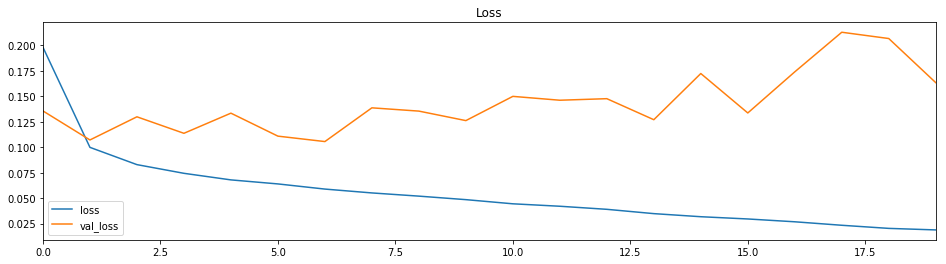

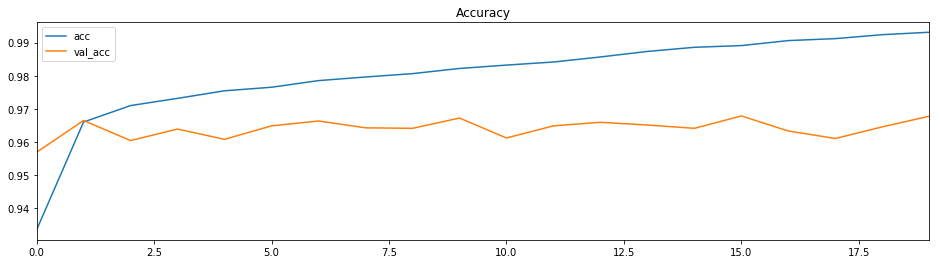

In [21]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [23]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'
ximg_test, xgt_test = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test', 2**-3)

In [24]:
ximg_test_superpixels       = util.readObject('pathSuperPixelesTest')

In [54]:
i = np.random.choice(len(ximg_test))
superpixels = ximg_test_superpixels[i]
img = ximg_test[i]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[i]], folderGroundThruth, 'test', 2**3)


In [55]:
print(i)
startTime = datetime.now()
visGT = np.zeros(img.shape[:2], dtype="float")
superpixels = listSuperPixelesProcessedTest[0]

for j in range(len(superpixels)) :
    if YTestToPred[0][j] == 'text' :    
        visGT[superpixels[j] == 255] = 0.2
    elif YTestToPred[0][j] == 'decoration' :
        visGT[superpixels[j] == 255] = 0.4
    elif YTestToPred[0][j] == 'comment' :
        visGT[superpixels[j] == 255] = 0.6
    elif YTestToPred[0][j] == 'page' :
        visGT[superpixels[j] == 255] = 0.8
    elif YTestToPred[0][j] == 'periphery' :
        visGT[superpixels[j] == 255] = 1

1


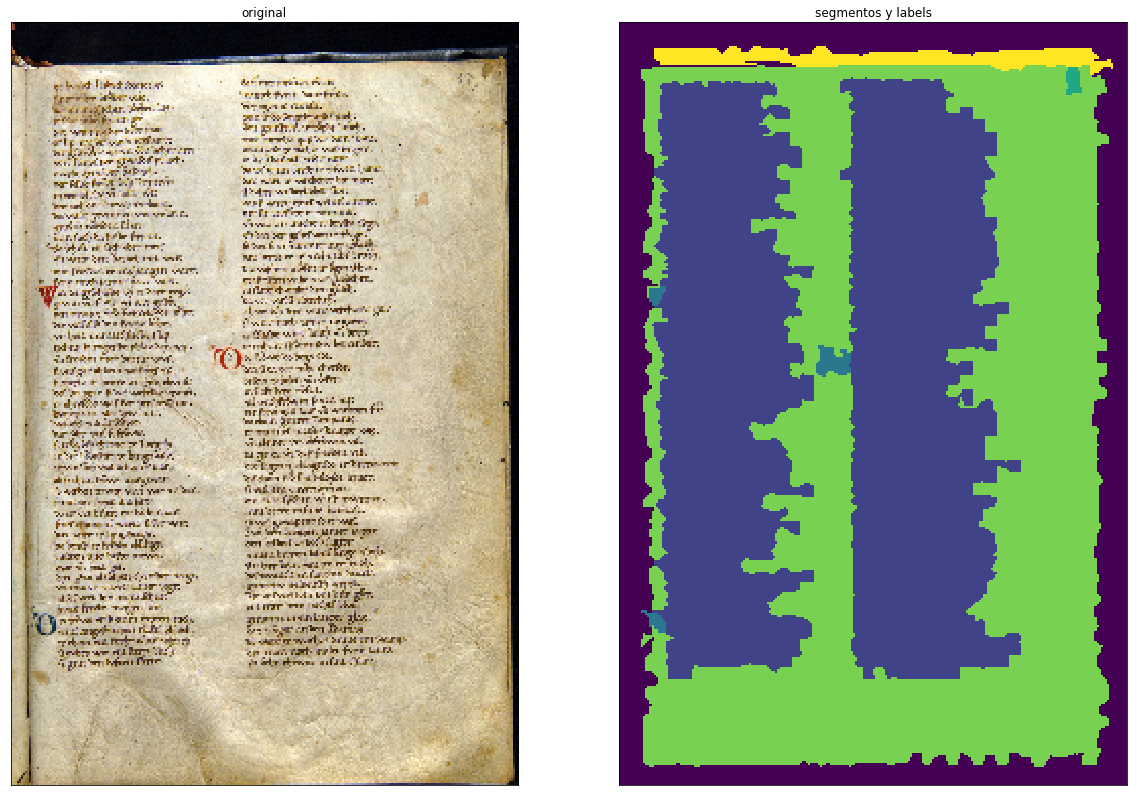

In [56]:
util.subplot(titles=['original','segmentos y labels'], images = [img, visGT], rows = 1, imgPerRows = 2, size = 20)


In [58]:
yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = model.predict_classes(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0]
        labels.append(predictedLabel)
    yPred.append(labels)

0:comment 1:decoration 2:page 3:periphery 4:text

In [60]:
startTime = datetime.now()
visPred = np.zeros(img.shape[:2], dtype="float")

for k in range(len(superpixels)) :
    if yPred[0][k] == 4 :    
        visPred[superpixels[k] == 255] = 0.2
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = 0.4
    elif yPred[0][k] == 0 :
        visPred[superpixels[k] == 255] = 0.6
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = 0.8
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = 1

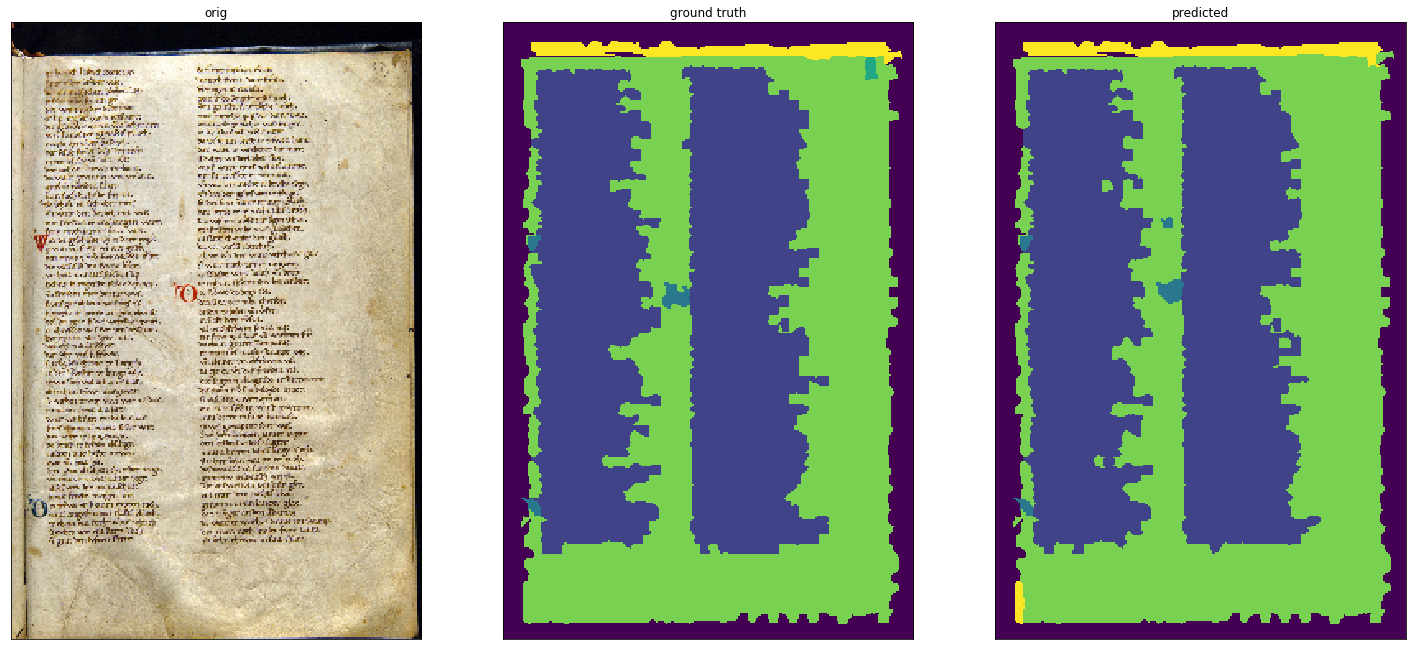

In [62]:
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])